<a href="https://colab.research.google.com/github/Henrique-Baumegger/myPersonalVisualComputing/blob/main/Exercises/W5/W5_exercise_MY_FINAL_SOLUTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# @title Quickstart for Google Colab
from pathlib import Path
if Path.cwd().name != 'W5_ex':
  !git clone --quiet https://github.com/tavisualcomputing/viscomp2025/
  %cd viscomp2025/Exercises/W5

/content/viscomp2025/Exercises/W5


# Week 5: PCA

The exercise of this week is about PCA. Run this notebook on Colab [following this link](https://colab.research.google.com/github/tavisualcomputing/viscomp2024/blob/main/Exercises/W5/W5_exercise.ipynb).

First load the following libraries that will be necessary and extract the dataset archive:

In [3]:
!pip install scipy
!pip install scikit-image
!pip install matplotlib
!unzip -q ./dataset.zip

In [4]:
%matplotlib inline
from skimage.io import imread
from scipy import signal,ndimage
import numpy as np
import time
import scipy.io as sio
from matplotlib.pyplot import imshow,show,figure
import skimage.transform as tf
import IPython
import scipy
from sys import getsizeof

# grid-based face image visualization
def make_grid(image_list,rows=5):
    cols = len(image_list)//rows
    row_image_list = []
    for c in range(cols):
        col_image_list = []
        for r in range(rows):
            col_image_list.append(image_list[c*rows+r])
        col_image = np.concatenate(col_image_list,axis=0)
        row_image_list.append(col_image)
    return np.concatenate(row_image_list,axis=1)

# Load images

We use the AT&T dataset, which consists of 40 people with 10 experssions each. We split the dataset into two parts, training images and test images. The training images will be used to extract the eigenfaces, which are then used to compress test images.

**First, we load the training data.** Here we take 5 expressions of 20 people as training set.

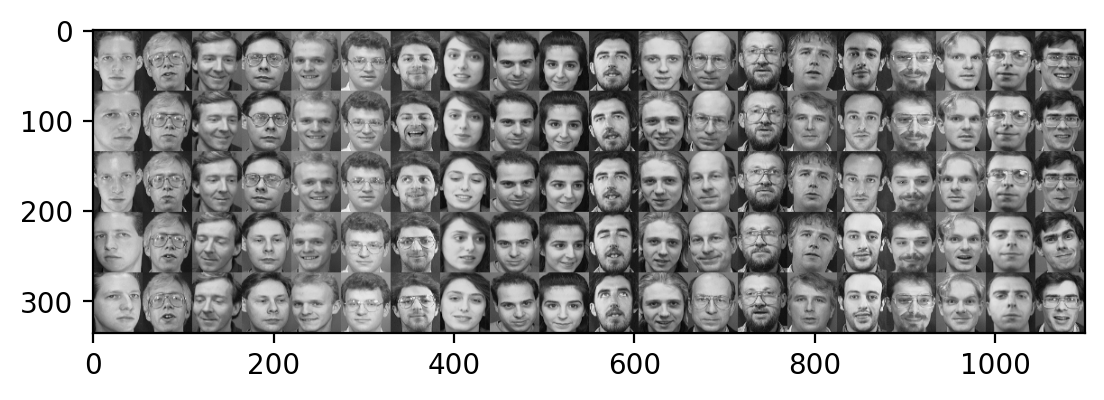

In [5]:
train_person_ids = np.arange(1,21)
train_expression_ids = np.arange(1,6)
train_image_list = []
for pid in train_person_ids:
    for eid in train_expression_ids:
        image = imread('dataset/s%d/%d.pgm'%(pid,eid))/255.  # scale image values to [0,1]
        image = tf.rescale(image,0.6)
        h,w = image.shape
        train_image_list.append(image)

train_image_collage = make_grid(train_image_list,rows=5)
fig = figure(dpi=200)
imshow(train_image_collage,cmap='gray')

**Then we load the test images.** To see if the method can deal with **unseen** identity and **unseen** expressions, we test with the rest 5 expressions of the rest 20 people.

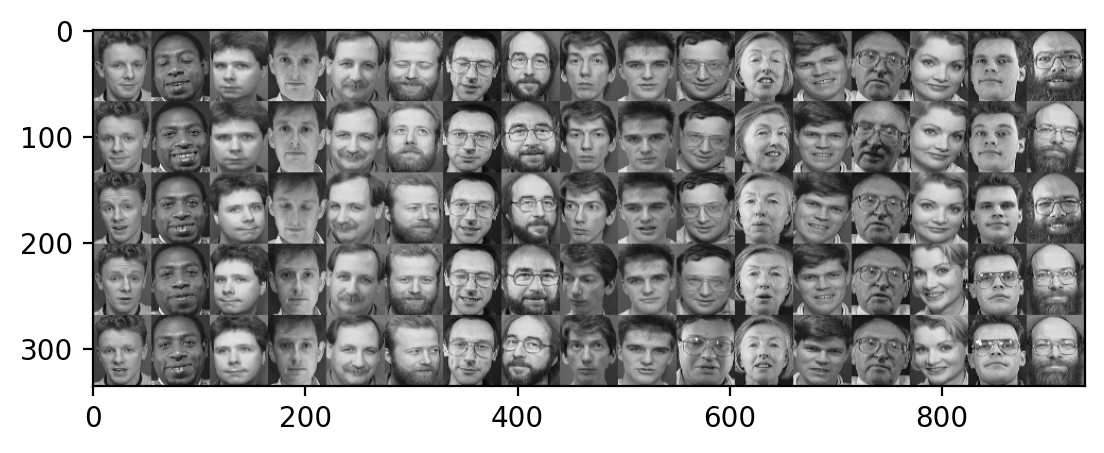

In [6]:
test_person_ids = np.arange(21,38)
test_expression_ids = np.arange(6,11)
test_image_list = []
for pid in test_person_ids:
    for eid in test_expression_ids:
        image = imread('dataset/s%d/%d.pgm'%(pid,eid))/255.
        image = tf.rescale(image,0.6)
        h,w = image.shape
        test_image_list.append(image)

test_image_collage = make_grid(test_image_list,rows=5)
figure(dpi=200)
imshow(test_image_collage,cmap='gray');

## Part A: Image Compression

In part A, we will use PCA to compress face images. For convenience we reshape the N training images into vectors of length $D = Height\times Width$ and concatenate all vectors to form a $D \times N$ matrix $X$.

In [8]:
image_vectors = [image.flatten() for image in train_image_list]
X = np.stack(image_vectors, axis=1)
print('data matrix shape', X.shape, ', sample number', X.shape[1], ', feature dimension', X.shape[0])

data matrix shape (3685, 100) , sample number 100 , feature dimension 3685


**Compute the mean and covariance of images.** The mean of images $\mu$ is a vector of length $D$ and can be visualized as an image. The covariance $\Sigma$ is a $D \times D$ matrix. You can use `numpy.mean()` and `numpy.cov()` for the computation.

mean matrix shape (3685, 1)
covariance matrix shape (3685, 3685)


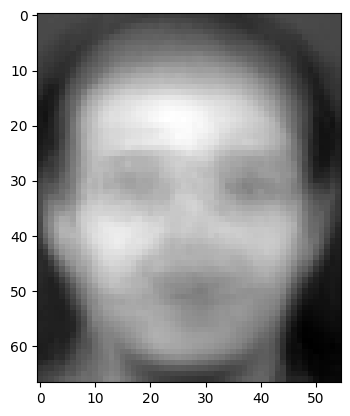

In [9]:

# columns (dimension 1) of X are different sampled objects
# rows (dimension 0) of X are variables of those samples


# Your lines here. Compute the mean.
mean = np.mean(X, axis=1, keepdims=True)
print('mean matrix shape', mean.shape)

# Your lines here. Compute the covariance.
# option 1: use numpy.cov()

# If rowvar is True (default), then each row (of input matrix) represents a variable, with observations in the columns.
# Otherwise, the relationship is transposed: each column (of input matrix) represents a variable, while the rows contain observations.

# covariance[a][b] represents the covariance between variables a and b
# covariance [d][d] represents variance of d
covariance = np.cov (X, rowvar = True)
print('covariance matrix shape', covariance.shape)

# option 2: compute covariance or auto-correlation matrix with matrix multiplication
# covariance and auto-correlation matrix have different normalization factors 1/(N-1) or 1/N.
# covariance = ...

imshow(mean.reshape(h,w),cmap='gray')

**Compute eigenfaces.** Eigenfaces are the eigenvectors correponding to k-largest eigenvalues of covariance matrix. You can use `scipy.sparse.linalg.eigs(mat,k)` to compute $k$ largest eigenvalues of $mat$ and corresponding eigenvectors $[u_1 ... u_k]$ . Note that this function returns the results in complex valued format, which needs to be converted to real numbers using `numpy.real()`. Alternatively, you can also compute eigenvectors via the SVD of $X$.

eigenvalues matrix shape (50,)
eigenvectors matrix shape (3685, 50)


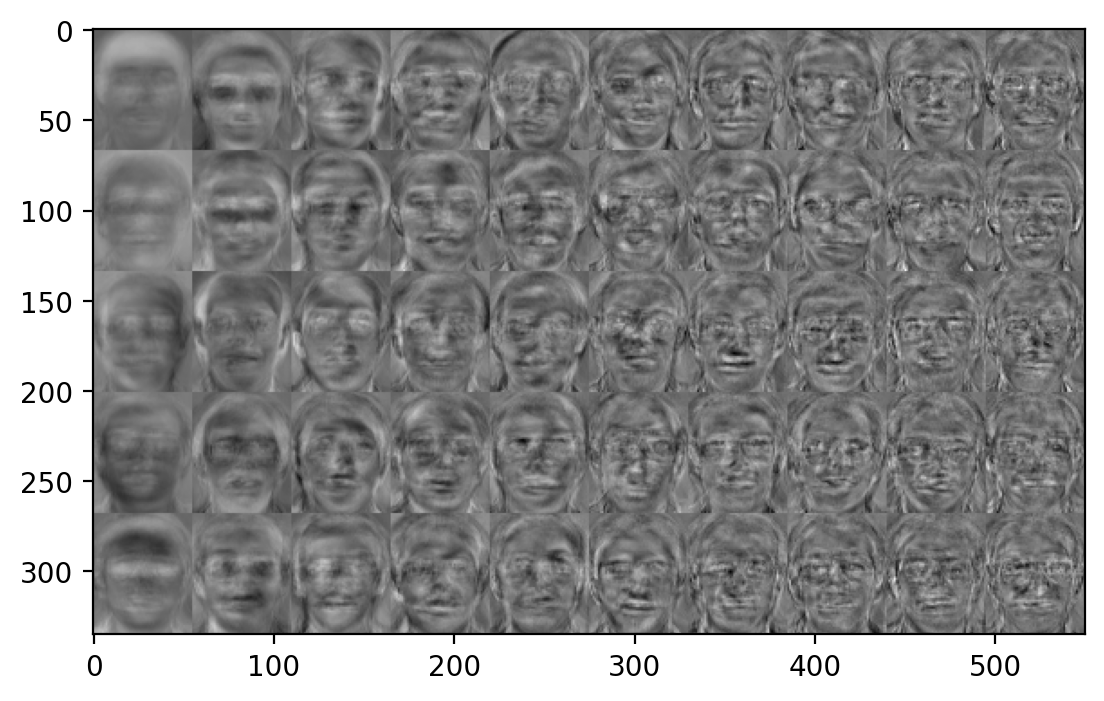

In [10]:
num_eigenvectors = 50 # k

# eigenvectors = # Your lines here. Compute the eigenfaces.
# optional 1: use scipy.sparse.linalg.eigs()
eigenvalues, eigenvectors = scipy.sparse.linalg.eigs(covariance, k=num_eigenvectors)
eigenvalues = np.real(eigenvalues)
eigenvectors = np.real(eigenvectors)

print('eigenvalues matrix shape', eigenvalues.shape)
print('eigenvectors matrix shape', eigenvectors.shape)


# optional 2: use manual SVD of covariance (or auto-correlation matrix)
# u, s, vh =
# eigenvectors = u[:, :num_eigenvectors]

basis_image_list = [eigenvector.reshape(h,w) for eigenvector in eigenvectors.T]
basis_image_collage = make_grid(basis_image_list,rows=5)
fig = figure(dpi=200)
imshow(basis_image_collage,cmap='gray')


**Now we can use the computed eigenfaces to compress images.** Face images can be approximated by linear combinations of eigenfaces $x=\mu + c_1 u_1 + c_2 u_2 + .... + c_k u_k$. Therefore, we can use the weights $[c_1 ... c_k]$ to record a image, instead of saving all pixels values. Each weight $c_i$ is the projection of the normalized image $\tilde{x} = x-\mu$ onto the corresponding eigenface $u_i$, which can be computed by dot product $c_i = \tilde{x} \cdot u_i$.

To recover a image from its compression we can use  $x=\mu + c_1 u_1 + c_2 u_2 + .... + c_k u_k$.


**Complete the lines below to compress a image into a $k$ dimensional vector.**

**Q:** Compress training images and test images. On which set the method works better? Why?

**Q:** Compress image with different number of eigenfaces. What's the influence of $k$?

**Q:** Considering that we want to reduce data size, what is the maximum value of $k$?

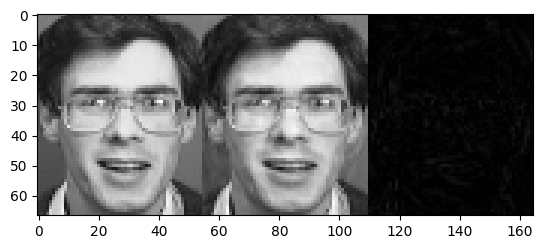

Size before compression: 29480 Bytes
Size after compression: 400 Bytes
ssd_error:  4.948600821220037


In [11]:
error_images = []
for image in train_image_list[:]:

    # Your lines here. Compress the image into a vector of lenght k (top-k eigen vectors).

    normalized_image = image.flatten() - mean.flatten() # normalized_image matrix shape (3685,)

    # Instead of using dot() we can simply multiply the matrixes
    # That will multiply each row of eigenvectors.T (eigenvector themselfs) with each the single column that is normalized_image
    compressed_image = eigenvectors.T @ normalized_image # compressed_image matrix shape (50, )
    # @ is shortcut for matmul




    # Your lines here. Decompress the image.
    decompressed_image = mean.flatten() + (eigenvectors @ compressed_image)



    error_image = np.abs(decompressed_image-image.flatten())
    error_images.append(error_image)

    imshow(np.concatenate([image.reshape(h,w),\
                          decompressed_image.reshape(h,w),\
                          error_image.reshape(h,w)],axis=-1),cmap='gray')

    IPython.display.clear_output(True)
    show()

print('Size before compression: %d Bytes'%image.nbytes)
print('Size after compression: %d Bytes'%compressed_image.nbytes)

error_images = np.stack(error_images,0)
ssd_error = (error_images**2).sum(-1).mean()
print('ssd_error: ', ssd_error)

# Part B: Face Detection with PCA
**In this part we will use PCA to detect faces.** In previous part, we have implemented a compressor for face images. Since the eigenvectors are extracted from faces images, we can expect that such a compressor would fail on other images, leading to erroneous decompression. This fact can be used for face detection.

You are given an image with a face and your task is to find the location of the face. The new image's height is same as the training dataset, so your task is simplified to find x coordinate only.
Try to compress and then decompress each part of the image using the method in part A, and then compute the SSD error. Based on the SSD error, find the localtion (x coordinate) where the face is located.

height 67 width 300


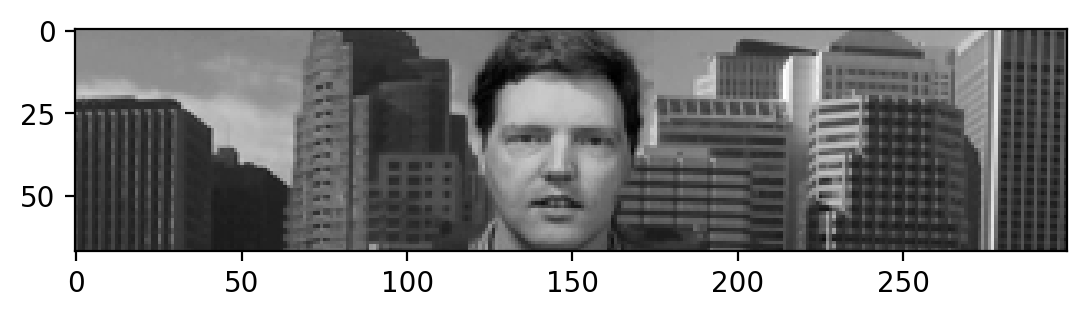

In [12]:
image = imread('FaceDetection.bmp')[:h,:]/255.
h_,w_ = image.shape
figure(dpi=200)
imshow(image,cmap='gray')
print('height', h_, 'width', w_)

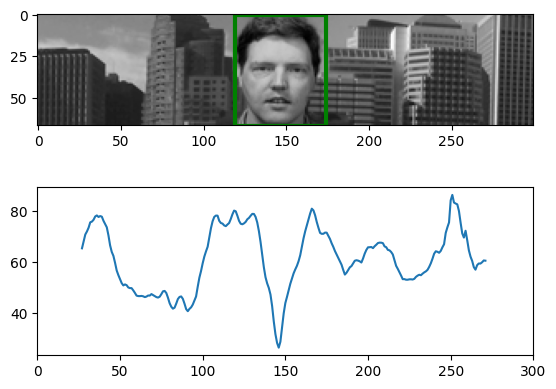

In [14]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

errors = []

# iterate over each part of the image
for x in range(w_-w): # Every horizontal pixel, except a right "border" smaller than our previous face sizes
    image_crop = image[:,x:x+w].flatten()

    # your lines here. Compress and decompress the image patch and compute the reconstruction error.
    # compress
    compressed_image = eigenvectors.T @ (image_crop.flatten() - mean.flatten()) # compressed_image matrix shape (50, )
    # decompress
    decompressed_image = mean.flatten() + (eigenvectors @ compressed_image)
    # error
    error = np.sum((image_crop - decompressed_image)**2)

    error_image = np.abs(image_crop - decompressed_image.flatten())
    local_reconstruction_vis = np.concatenate([image_crop.reshape(h,w), decompressed_image.reshape(h,w), error_image.reshape(h,w)], axis=-1)
    errors.append(error)

    fig, ax = plt.subplots(3,1)
    rect = patches.Rectangle((x,0),w,h,linewidth=3,edgecolor='r',facecolor='none')
    ax[0].imshow(image,cmap='gray')
    ax[0].add_patch(rect)
    ax[1].imshow(local_reconstruction_vis,cmap='gray')
    ax[2].plot(np.arange(x+1)+w//2,np.array(errors))
    ax[2].set_xlim([0,w_])
    IPython.display.clear_output(True)
    show()

x_best = np.argmin(errors)
fig, ax = plt.subplots(2,1)
rect = patches.Rectangle((x_best,0),w,h,linewidth=3,edgecolor='g',facecolor='none')

ax[0].imshow(image,cmap='gray')
ax[0].add_patch(rect)
ax[1].plot(np.arange(x+1)+w//2,np.array(errors))
ax[1].set_xlim([0,w_])
IPython.display.clear_output(True)
show()

# Part C: Exam question

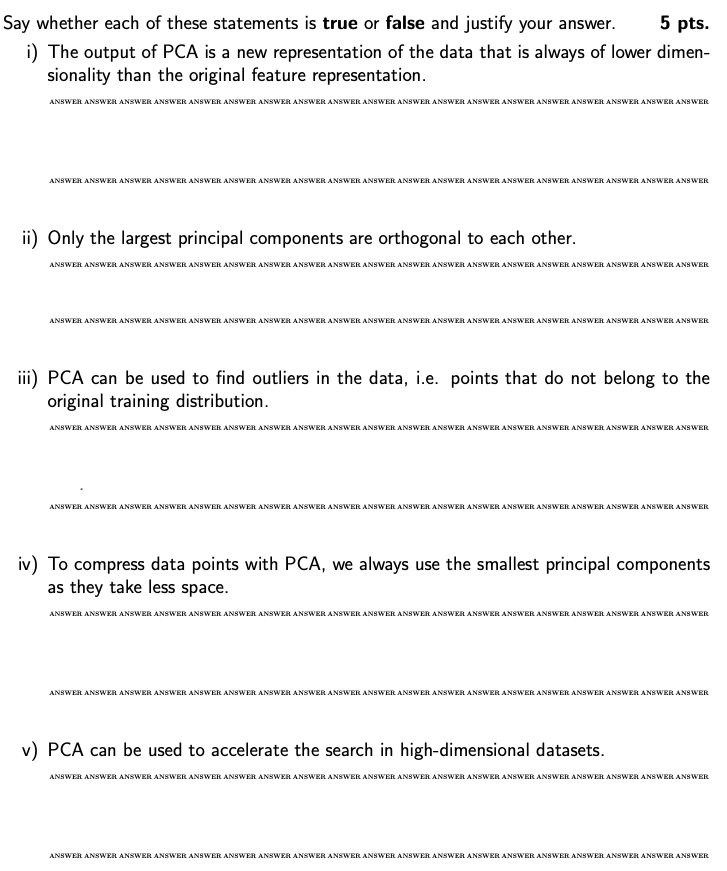

1) False.  PCA gives you a new coordinate system (the principal components). You choose how many components to keep. If you keep all of them, the dimensionality stays the same. Only when you choose fewer components (say, keep 2 out of 10), you get lower dimensionality.

2) False. All principal components (not just the largest ones) are orthogonal (perpendicular) to each other by definition.

3) True. PCA captures the main directions of variance in the training data. If you project a new data point onto this PCA space and it reconstructs very poorly (large reconstruction error), that means it does not fit the learned distribution.

4) False. We use the largests (or all of them).

5) True.